In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
def autolabelint(ax,rects,fsize,col):
    for rect in rects:
        ax.text(rect.get_x() + rect.get_width()/2 ,
            rect.get_height(),
            '%d' % int(rect.get_height()),
            ha='center',
            va='bottom',
            fontweight='bold',
            color = col,
            fontsize = ((fsize[1]+fsize[0])/2) + 5
           )

In [3]:
train = pd.read_csv("../train.csv")

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
finger = train.drop(columns=["keyword","location","id"])

In [6]:
def non_alphanum(x):
    return len(re.findall(r'[^a-zA-Z0-9 ]',x))
def hashtags(x): 
    return len(re.findall(r'#[a-zA-z0-9_]',x))
def arrobas(x):
    return len(re.findall(r'@[a-zA-z0-9_]',x))
def expresion(x):
    return (x.count('?') + x.count('!'))
def urls(x):
    re.findall(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?')
finger[["Caracteres","Palabras",\
            "Caracteres no alfanuméricos","Caracteres de expresión !?",\
                "Etiquetas", "Menciones"]] \
= finger["text"].apply(lambda x: pd.Series([len(x),len(x.split(" "))\
                                    ,non_alphanum(x),expresion(x)
                                            ,hashtags(x),arrobas(x)]))

finger["Caracteres no alfanuméricos"] = \
finger["Caracteres no alfanuméricos"] - finger["Etiquetas"] \
                                        - finger["Menciones"]

finger.drop(columns=["text"],inplace=True)
finger.head()

,target,Caracteres,Palabras,Caracteres no alfanuméricos,Caracteres de expresión !?,Etiquetas,Menciones
0,1,69,13,0,0,1,0
1,1,38,7,1,0,0,0
2,1,133,22,3,0,0,0
3,1,65,9,1,0,1,0
4,1,88,17,0,0,2,0


Text(0,0.5,'')

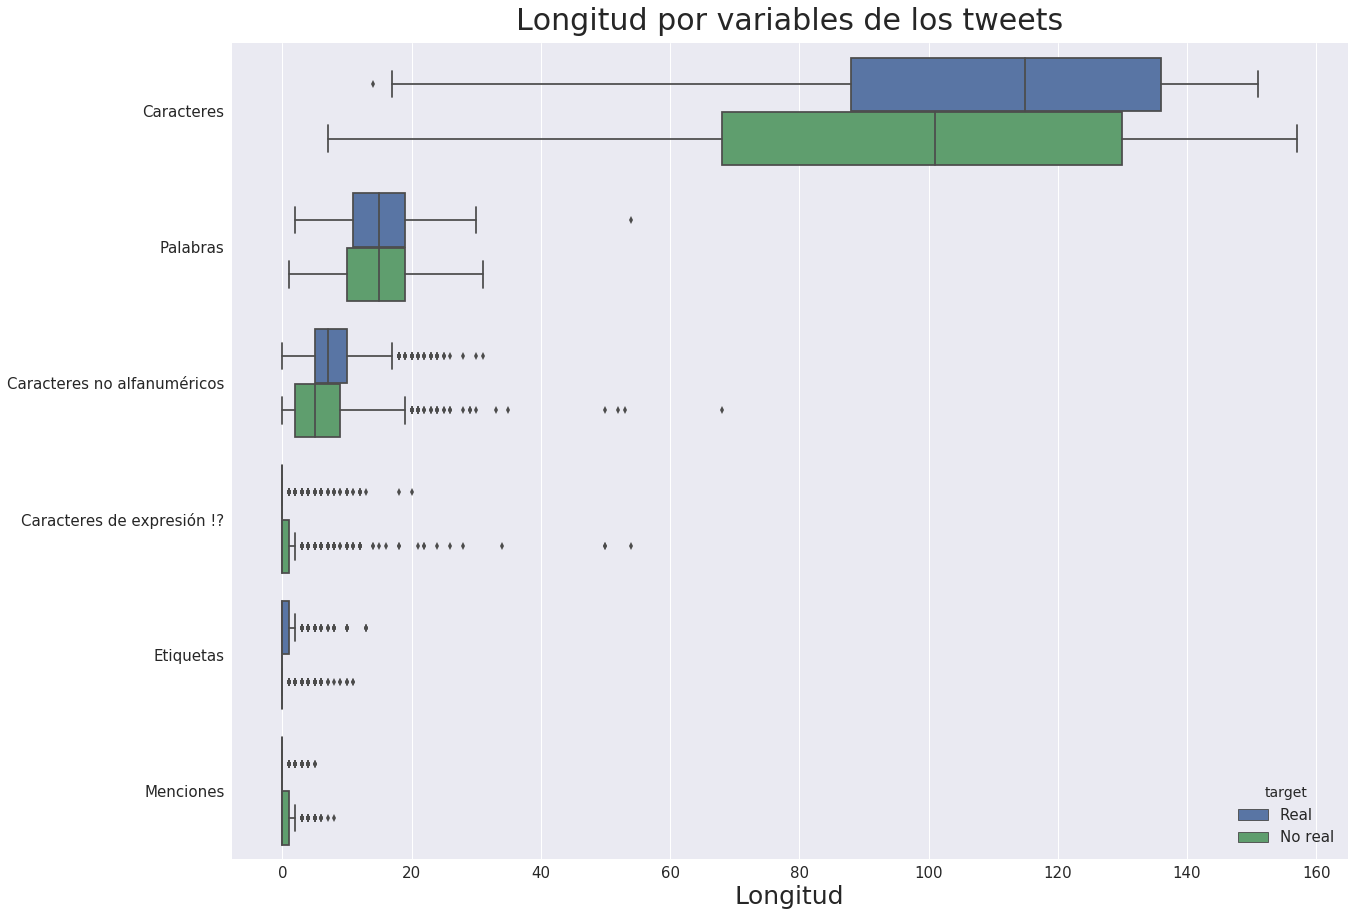

In [7]:
melted = pd.melt(finger, id_vars="target")
melted.loc[melted["target"] == 0, "target"] = "No real"
melted.loc[melted["target"] == 1, "target"] = "Real"
melted.rename(columns={"value":"Longitud","variable":"Variables"},inplace=True)
sns.set(rc={'figure.figsize':(20,15)})
sns.set(font_scale=1.5)
plot = sns.boxplot(x='Longitud',y="Variables",data=melted,hue='target')
plot.axes.set_title('Longitud por variables de los tweets',fontsize=30, y=1.009)
plot.set_xlabel("Longitud",fontsize=25)
plot.set_ylabel("",fontsize=0)
#plot.get_figure().savefig("finger.png")

Uso expresiones regulares para hallar menciones, etiquetas y URLs en los tweets.

In [8]:
def get_links(x):
    links = list()
    l = re.findall(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?',x)
    #for tup in l:
    #    links.append(chase_redirects(tup[0] + "://" + ''.join(tup[1:])))
    return l

def hashtags(x): 
    return re.findall(r'#[a-zA-z0-9_]{1,}',x)
def arrobas(x):
    return re.findall(r'@[a-zA-z0-9_]{1,}',x)

train[["Menciones","Etiquetas","Enlaces"]] =\
                        train["text"].apply(lambda x: pd.Series([arrobas(x),hashtags(x),get_links(x)]))

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 8 columns):
id           7613 non-null int64
keyword      7552 non-null object
location     5080 non-null object
text         7613 non-null object
target       7613 non-null int64
Menciones    7613 non-null object
Etiquetas    7613 non-null object
Enlaces      7613 non-null object
dtypes: int64(2), object(6)
memory usage: 475.9+ KB


/home/mariano/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/mariano/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/mariano/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

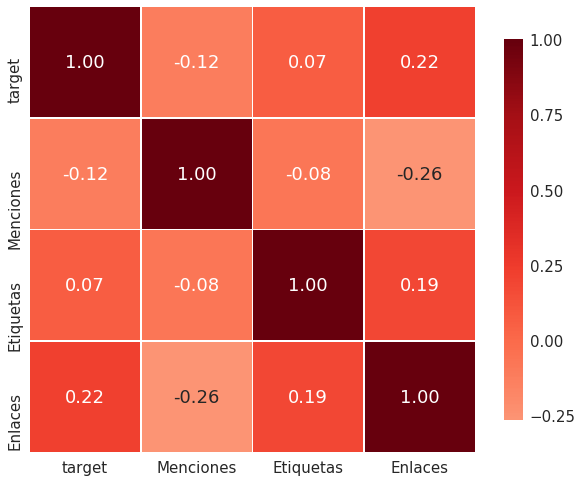

In [10]:
def correlation_heatmap(df):
    normalized_df=(df-df.mean())/df.std()
    correlations = normalized_df.corr(method='spearman')

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True,cmap="Reds", cbar_kws={"shrink": .70})
    plt.show();

cantidades = train[["target","Menciones","Etiquetas","Enlaces"]]

cantidades["Menciones"] = cantidades["Menciones"].apply(lambda x: len(x))
cantidades["Etiquetas"] = cantidades["Etiquetas"].apply(lambda x: len(x))
cantidades["Enlaces"] = cantidades["Enlaces"].apply(lambda x: len(x))
correlation_heatmap(cantidades)

/home/mariano/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/mariano/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/mariano/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

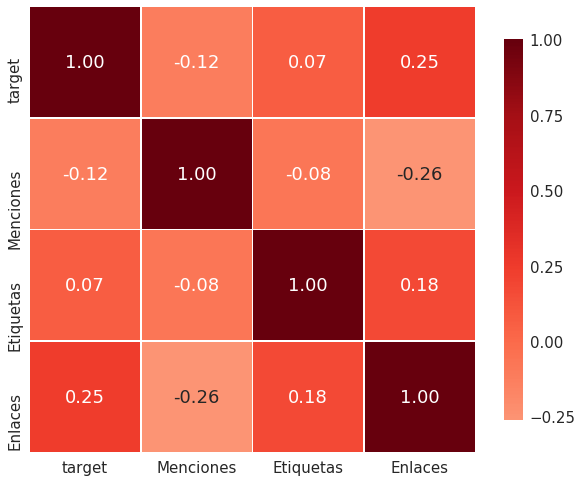

In [11]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True,cmap="Reds", cbar_kws={"shrink": .70})
    plt.show();

cantidades = train[["target","Menciones","Etiquetas","Enlaces"]]

cantidades["Menciones"] = cantidades["Menciones"].apply(lambda x: 0 if len(x) == 0 else 1)
cantidades["Etiquetas"] = cantidades["Etiquetas"].apply(lambda x: 0 if len(x) == 0 else 1)
cantidades["Enlaces"] = cantidades["Enlaces"].apply(lambda x: 0 if len(x) == 0 else 1)

correlation_heatmap(cantidades)

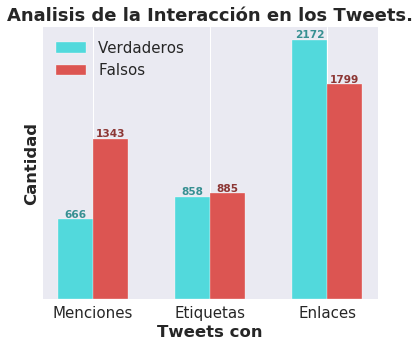

In [12]:
fsize = (6,5)
fig, ax = plt.subplots(figsize=fsize)
false = cantidades.loc[cantidades["target"] == 0]
true = cantidades.loc[cantidades["target"] == 1]
bars1 = [true["Menciones"].sum(),true["Etiquetas"].sum(),true["Enlaces"].sum()]
bars2 = [false["Menciones"].sum(),false["Etiquetas"].sum(),false["Enlaces"].sum()]
r1 = np.arange(len(bars1))
r2 = [x + 0.3 for x in r1]
rects1 = ax.bar(r1, bars1, color='#52D9DC', width=0.3, edgecolor='white', label='Verdaderos')
rects2 = ax.bar(r2, bars2, color='#DC5552', width=0.3, edgecolor='white', label='Falsos')

ax.set_title('Analisis de la Interacción en los Tweets.',fontweight='bold')
ax.set_ylabel('Cantidad',fontweight='bold')
ax.set_yticks([])
ax.xaxis.set_ticks_position('none')
plt.xlabel('Tweets con', fontweight='bold')
plt.xticks([r+0.15 for r in range(len(bars1))], ['Menciones', 'Etiquetas', 'Enlaces'])
autolabelint(ax,rects1,fsize,'#379092')
autolabelint(ax,rects2,fsize,'#8C3634')
plt.legend()

#### Limpieza de menciones

In [13]:
menciones = train.loc[train["Menciones"].str.len() > 0, ["Menciones","target"]]
print("Total de menciones: ",len(menciones["Menciones"].sum()))
# Menciones unicas por tweet
print("Total de menciones sin duplicados dentro de los tweets:  ",\
     len(menciones["Menciones"].apply(lambda x: list(set(x))).sum()))

Total de menciones:  2715
Total de menciones sin duplicados dentro de los tweets:   2708


In [14]:
def duplicada(x):
    if len(x) == len(set(x)):
        return False
    else:
        return True
menciones["mencion_duplicada"] = menciones["Menciones"].apply(duplicada)

In [15]:
menciones.loc[menciones["mencion_duplicada"]]

,Menciones,target,mencion_duplicada
1449,"[@GreenHarvard, @GreenHarvard]",1,True
1781,"[@meinlcymbals, @meinlcymbals]",0,True
1994,"[@IndiGo6E, @the, @the]",0,True
3205,"[@TfLBusAlerts, @TfLBusAlerts]",1,True
4999,"[@TeamHendrick, @TeamHendrick, @RIRInsider, @n...",0,True
5640,"[@KristinDavis, @UN, @Refugees, @UN, @Refugees]",0,True


cómo no tienen mucho significado y solamente se repiten 2 veces, voy a desecharlas

In [16]:
menciones.drop(columns = ["mencion_duplicada"],inplace=True)
menciones["Menciones"] = menciones["Menciones"].apply(lambda x: list(set(x)))

In [17]:
pd.Series(menciones["Menciones"].sum()).value_counts()

@YouTube            82
@ArianaGrande       11
@POTUS               9
@Change              9
@FoxNews             9
@emmerdale           8
@djicemoon           7
@justinbieber        7
@Towel               6
@Stretcher           6
@MikeParrActor       6
@YoungHeroesID       5
@ViralSpell          5
@usatoday            5
@USAgov              5
@invalid             5
@AP                  5
@Reuters             4
@unsuckdcmetro       4
@KurtSchlichter      4
@RaynbowAffair       4
@USATODAY            4
@Grazed              4
@worldnetdaily       4
@local_arsonist      4
@Rexyy               4
@Michael5SOS         4
@DiamondKesawn       4
@LoneWolffur         4
@nytimes             3
                    ..
@Jannellix0          1
@ticklemeshawn       1
@Z3KE_SK1            1
@mockingpanems       1
@SnowyWolf5          1
@wwp                 1
@sopameer            1
@samajp32            1
@zeno001             1
@HalloIkBenWill      1
@bigperm28           1
@CiaraMcKendry       1
@Louis_Toml

In [18]:
pd.Series(menciones["Menciones"].loc[menciones["target"] == 0].sum()).value_counts()

@YouTube            65
@ArianaGrande       11
@justinbieber        7
@emmerdale           7
@djicemoon           7
@MikeParrActor       6
@Towel               5
@invalid             5
@Stretcher           5
@Change              5
@worldnetdaily       4
@RaynbowAffair       4
@LoneWolffur         4
@DiamondKesawn       4
@Grazed              4
@local_arsonist      4
@realmandyrain       3
@NickCannon          3
@iTunesMusic         3
@TinyJecht           3
@USATODAY            3
@dannyonpc           3
@Blizzard_draco      3
@GOP                 3
@TrubGME             3
@iTunes              3
@YoungHeroesID       3
@Rexyy               3
@Foxy__Siren         3
@spinningbot         3
                    ..
@leiaorganasolo      1
@DaneMillar1         1
@AcaciaPenn          1
@LeeJasper           1
@samihonkonen        1
@kessily             1
@blanksocietyx       1
@Forbes              1
@PlayOverwatch       1
@Jannellix0          1
@ticklemeshawn       1
@ZachZaidman         1
@mockingpan

In [19]:
pd.Series(menciones["Menciones"].loc[menciones["target"] == 1].sum()).value_counts()

@YouTube            17
@FoxNews             8
@POTUS               6
@AP                  5
@USAgov              5
@unsuckdcmetro       4
@Change              4
@NASAHurricane       3
@Reuters             3
@KurtSchlichter      3
@ViralSpell          3
@usatoday            3
@sharethis           3
@Michael5SOS         3
@smh                 3
@MNPDNashville       3
@Newz_Sacramento     2
@cjoyner             2
@weathernetwork      2
@themagickidraps     2
@peterjukes          2
@newyorker           2
@wordpressdotcom     2
@guardian            2
@BLutz10             2
@samanthaturne19     2
@RoyalCarribean      2
@gofundme            2
@TfLBusAlerts        2
@LivingSafely        2
                    ..
@NashvilleFD         1
@TeamStream          1
@RobertHarding       1
@CSAresu             1
@DroughtGov          1
@instapundit         1
@pmarca              1
@KellKane            1
@Lolly_Knickers      1
@cityofcalgary       1
@mattburgener        1
@Habbo               1
@Vagersedol

In [20]:
menciones_separadas = pd.concat([menciones,menciones["Menciones"].apply(lambda x: pd.Series(x))],axis=1)
menciones_separadas.head()
#menciones_separadas.loc[~menciones_separadas[3].isna()]

,Menciones,target,0,1,2,3,4,5,6,7
31,[@bbcmtd],1,@bbcmtd,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,[@PhDSquares],0,@PhDSquares,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,[@southridgelife],0,@southridgelife,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,[@Alexis_Sanchez],0,@Alexis_Sanchez,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,"[@Navista7, @News24680]",1,@Navista7,@News24680,NaN,NaN,NaN,NaN,NaN,NaN


### URLS - ENLACES

In [21]:
links = pd.read_csv("redirected_links.csv",names=["Enlace Real"],  converters={'Enlace Real': eval})
links.head()

,Enlace Real
0,[]
1,[]
2,[]
3,[]
4,[]


In [22]:
train = pd.merge(links, train, right_index=True, left_index=True)

In [23]:
train.dtypes

Enlace Real    object
id              int64
keyword        object
location       object
text           object
target          int64
Menciones      object
Etiquetas      object
Enlaces        object
dtype: object

In [24]:
train.loc[train["Enlace Real"].str.len() > 0]

,Enlace Real,id,keyword,location,text,target,Menciones,Etiquetas,Enlaces
31,[https://twitter.com/dannypurewal/status/62928...,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,[@bbcmtd],[],"[(http, t.co, /lHYXEOHY6C)]"
32,[https://twitter.com/Valis_Ablaze/status/62927...,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,[],"[#metal, #RT]","[(http, t.co, /YAo1e0xngw)]"
33,[https://africanbaze.com/breaking-newsnigeria-...,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,[],[#AFRICANBAZE],"[(http, t.co, /2nndBGwyEi)]"
35,[https://twitter.com/AnyOtherAnnaK/status/6291...,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,[],[],"[(http, t.co, /qqsmshaJ3N)]"
37,[https://www.yabaleftonline.ng],55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1,[],[],"[(http, t.co, /3ImaomknnA)]"
38,[https://www.youtube.com/watch?v=yG08hLEWzyM],56,ablaze,NaN,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...,1,[],[#Bridgetown],"[(http, t.co, /wDUEaj8Q4J)]"
40,[http://freewebcamsex.me/2015-02-02-taking-in-...,59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0,[],[#nsfw],"[(http, t.co, /rOI2NSmEJJ), (http, t.co, /3Tj8..."
44,[https://twitter.com/RevDominic/status/6292723...,64,ablaze,NaN,I wanted to set Chicago ablaze with my preachi...,0,[],[],"[(http, t.co, /o9qknbfOFX)]"
45,[https://www.crowdfireapp.com/?utm_source=week...,65,ablaze,NaN,I gained 3 followers in the last week. You? Kn...,0,[],[],"[(http, t.co, /TIyUliF5c6)]"
46,[https://mashable.com/2015/08/04/how-the-west-...,66,ablaze,"GREENSBORO,NORTH CAROLINA",How the West was burned: Thousands of wildfire...,1,[],[],"[(http, t.co, /vl5TBR3wbr)]"


In [25]:
lista = list()
def get_domain(string):
    for s in string.split("/"):
        if "." in s:
            return s.replace("www.","")
for index,row in train.loc[train["Enlace Real"].str.len()>0].iterrows():
    for url in row["Enlace Real"]:
        lista.append([index, url, row["target"],get_domain(url)])
        

In [26]:
enlaces_target = pd.DataFrame(data=lista,columns=["id","Enlace","target","Dominio"])

In [27]:
new = enlaces_target.drop(columns={"id","Enlace"})
new["Cantidad"] = 1
new = new.groupby(["target","Dominio"]).count().reset_index()

In [28]:
new.head()

,target,Dominio,Cantidad
0,0,1.usa.gov,2
1,0,24x7freeadvice.wordpress.com,1
2,0,2northstreet.com,2
3,0,99u.adobe.com,1
4,0,9jacruz.blogspot.com,1


In [29]:

arrTrue = enlaces_target.where(enlaces_target.target == 1).Dominio.value_counts()
dfTrue = pd.DataFrame({'Dominio': arrTrue.index, 'cant_verdaderos': arrTrue.values})

arrFalse = enlaces_target.where(enlaces_target.target == 0).Dominio.value_counts()
dfFalse = pd.DataFrame({'Dominio': arrFalse.index, 'cant_falsos': arrFalse.values})

dfJoin = pd.merge(dfTrue, dfFalse, how='inner', on='Dominio')
dfJoin.head(5)

,Dominio,cant_verdaderos,cant_falsos
0,twitter.com,479,602
1,bbc.co.uk,62,2
2,youtube.com,55,110
3,abcnews.go.com,49,5
4,facebook.com,40,51


In [30]:
dfJoin["cant_total"] = dfJoin["cant_verdaderos"] + dfJoin["cant_falsos"]

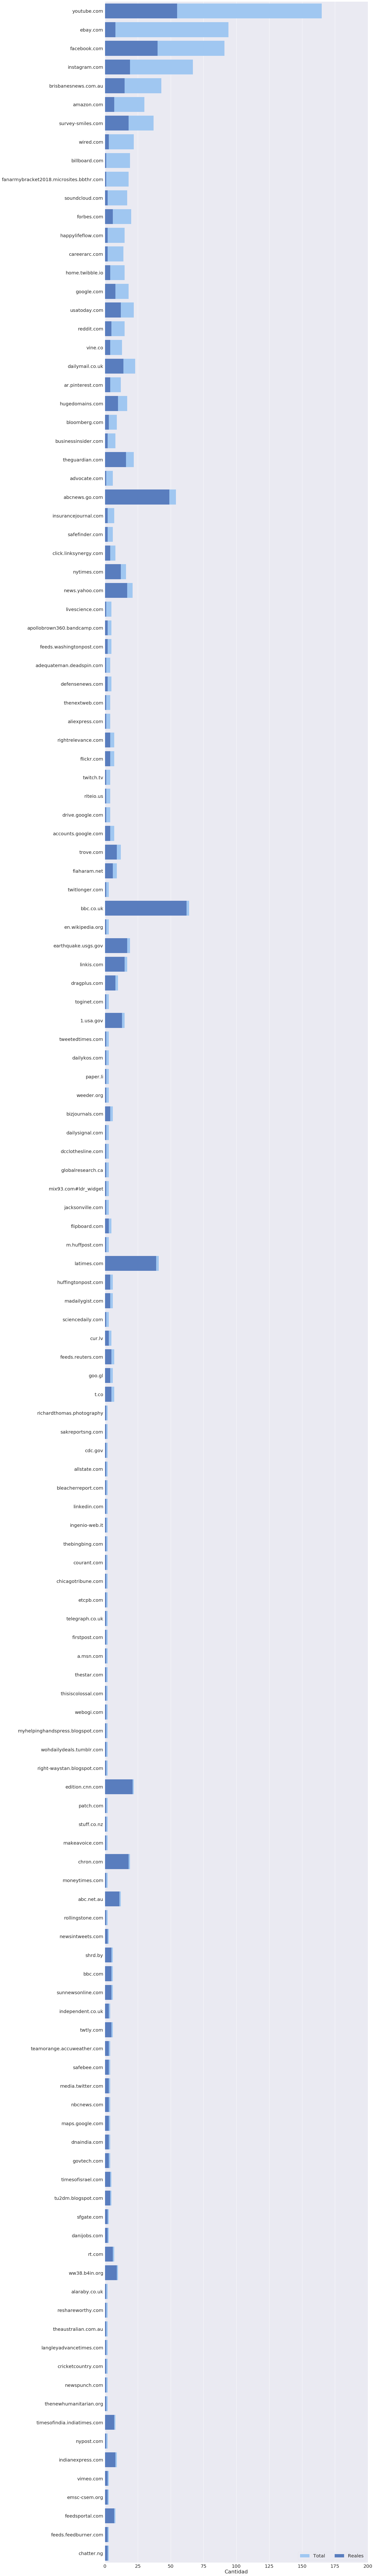

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Initialize the matplotlib figure
sns.set(font_scale=2)  # crazy big
f, ax = plt.subplots(figsize=(20, 200))

# Load the example car crash dataset
crashes = dfJoin.sort_values("cant_falsos", ascending=False)
crashes = crashes.iloc[1:,:]
# Plot the total crashes

sns.set_color_codes("pastel")
sns.barplot(x="cant_total", y="Dominio", data=crashes,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="cant_verdaderos", y="Dominio", data=crashes,
            label="Reales", color="b")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 200), ylabel="",
       xlabel="Cantidad")

sns.despine(left=True, bottom=True)

In [64]:
enlaces_target.loc[(enlaces_target["Dominio"].str.contains("twitter")) & (enlaces_target["Enlace"].str.contains("photo"))]

,id,Enlace,target,Dominio
0,31,https://twitter.com/dannypurewal/status/629284...,1,twitter.com
3,35,https://twitter.com/AnyOtherAnnaK/status/62919...,0,twitter.com
10,44,https://twitter.com/RevDominic/status/62927230...,0,twitter.com
20,52,https://twitter.com/BarbadosToday/status/62913...,0,twitter.com
22,54,https://twitter.com/Alexis_Sanchez/status/6290...,0,twitter.com
23,55,https://twitter.com/dwlazar/status/62914056137...,1,twitter.com
24,56,https://twitter.com/crimeairnetwork/status/629...,1,twitter.com
27,59,https://twitter.com/MikeHudema/status/62909280...,1,twitter.com
31,65,https://twitter.com/dannypurewal/status/629285...,1,twitter.com
43,90,https://twitter.com/theyhateosh_/status/629354...,0,twitter.com


In [65]:
enlaces_target.loc[(enlaces_target["Dominio"].str.contains("twitter")) & (enlaces_target["Enlace"].str.contains("video"))]

,id,Enlace,target,Dominio
1,32,https://twitter.com/Valis_Ablaze/status/629274...,0,twitter.com
82,163,https://twitter.com/AwaisBinYounas/status/6271...,1,twitter.com
96,185,https://twitter.com/hugotherealboss/status/629...,0,twitter.com
420,672,https://twitter.com/jay_dot_blaze/status/62908...,0,twitter.com
478,911,https://twitter.com/fbgchoppa/status/629105740...,0,twitter.com
543,998,https://twitter.com/iSeeYouGotjokes/status/628...,0,twitter.com
547,1014,https://twitter.com/MacDaddy_Leo/status/628001...,1,twitter.com
1212,2408,https://twitter.com/Cook79Pc/status/6293524000...,1,twitter.com
1914,3636,https://twitter.com/LeanandCuisine/status/5921...,0,twitter.com
2179,4121,https://twitter.com/RobinMcLeavy/status/629069...,1,twitter.com


In [77]:
enlaces_target.loc[(enlaces_target["Dominio"].str.contains("twitter")) &\
                   (enlaces_target["Enlace"].str.contains("https://twitter.com/account/suspended"))]

,id,Enlace,target,Dominio
49,104,https://twitter.com/account/suspended,0,twitter.com
51,106,https://twitter.com/account/suspended,0,twitter.com
54,114,https://twitter.com/account/suspended,0,twitter.com
56,115,https://twitter.com/account/suspended,0,twitter.com
58,116,https://twitter.com/account/suspended,0,twitter.com
60,118,https://twitter.com/account/suspended,0,twitter.com
62,119,https://twitter.com/account/suspended,0,twitter.com
107,199,https://twitter.com/account/suspended,0,twitter.com
118,218,https://twitter.com/account/suspended,1,twitter.com
120,220,https://twitter.com/account/suspended,1,twitter.com


In [81]:
enlaces_target.loc[(enlaces_target["Dominio"].str.contains("twitter")) &\
                   (~enlaces_target["Enlace"].str.contains("video")) &\
                   (~enlaces_target["Enlace"].str.contains("photo")) &\
                   (~enlaces_target["Enlace"].str.contains("https://twitter.com/account/suspended"))]

,id,Enlace,target,Dominio
17,50,https://chroniclet.com?utm_source=twitterfeed&...,1,chroniclet.com?utm_source=twitterfeed&utm_medi...
39,76,https://twitter.com/thelaunchmag/status/628230...,0,twitter.com
47,100,https://twitter.com/SayedYousif/status/6260876...,1,twitter.com
52,113,https://twitter.com/urdemianswers/status/61643...,0,twitter.com
83,168,https://twitter.com/emergenza24/status/6273505...,1,twitter.com
84,169,https://twitter.com/greysquestions/status/6163...,1,twitter.com
92,179,https://twitter.com/quiboatnews,0,twitter.com
114,204,https://feedsportal.com?utm_source=feedburner&...,1,feedsportal.com?utm_source=feedburner&utm_medi...
122,223,https://twitter.com/rob_politics/status/628993...,0,twitter.com
124,227,https://twitter.com/The_NewArab/status/6290379...,1,twitter.com
